In [1]:
%config InlineBackend.figure_formats = ['svg']
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [2]:
from model.layers import NestedDropout
from model.cmpnts import MLP, SNMLP
from model.layers import SNLinearCombo
from torch.linalg import svd

# 2D
## 1D Manifold

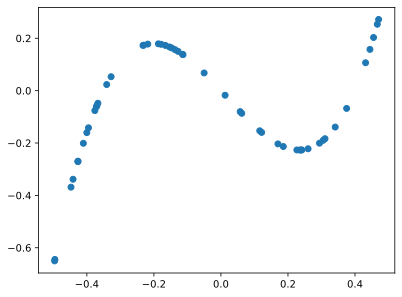

In [86]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [87]:
data = torch.stack([X, Y], dim=-1).to('cuda:0')

encoder = MLP(2, 2, [32]*4).to('cuda:0')
decoder = SNMLP(2, 2, [32]*4).to('cuda:0')
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(5000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    vol_loss = torch.exp(torch.log(z.std(0) + 0).mean())
    loss = rec_loss + 0.001 * vol_loss
    loss.backward()
    opt.step()

    if (i+1) % 500 == 0:
        print('Epoch {}: rec = {}, vol = {}'.format(i, rec_loss, vol_loss))

Epoch 499: rec = 2.6269731279171538e-06, vol = 0.12150371074676514
Epoch 999: rec = 1.063009449353558e-06, vol = 0.0731445699930191
Epoch 1499: rec = 7.860371056267468e-07, vol = 0.040352024137973785
Epoch 1999: rec = 6.449315606005257e-07, vol = 0.10200497508049011
Epoch 2499: rec = 9.076540663954802e-06, vol = 0.03760050982236862
Epoch 2999: rec = 1.7458997945141164e-06, vol = 0.058077700436115265
Epoch 3499: rec = 1.3354979273572098e-05, vol = 0.0746021419763565
Epoch 3999: rec = 6.824739102739841e-06, vol = 0.05609830841422081
Epoch 4499: rec = 5.943800260865828e-06, vol = 0.0642688050866127
Epoch 4999: rec = 3.924551947420696e-06, vol = 0.03073994070291519


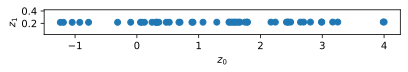

In [88]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    z = encoder(data)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.ylim(z.mean(0)[idx[1]].cpu().detach()-0.2, z.mean(0)[idx[1]].cpu().detach()+0.2)
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

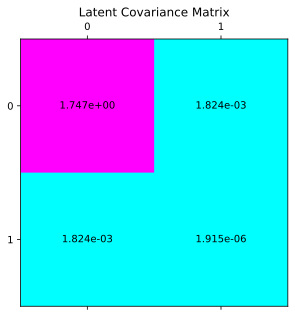

In [89]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

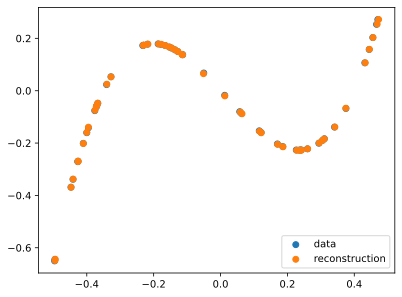

In [90]:
rec = decoder(z).cpu().detach().numpy()
plt.scatter(X.numpy(), Y.numpy(), label='data')
plt.scatter(rec[:, 0], rec[:, 1], label='reconstruction')
plt.legend()

## 2D Manifold

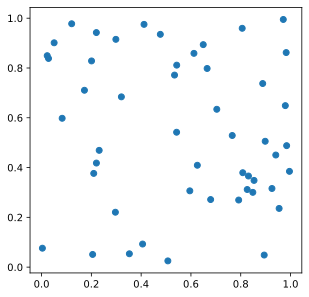

In [33]:
data = torch.rand(50, 2)
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.gca().set_aspect('equal')
plt.show()

In [35]:
encoder = MLP(2, 2, [32, 32, 32]) # MLP(2, 2, [32, 32, 32]) 
decoder = SNMLP(2, 2, [32, 32, 32])
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(5000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    vol_loss = torch.exp(torch.log(z.std(0)+1).mean())
    loss = rec_loss + 0.001 * vol_loss
    loss.backward()
    opt.step()

    if (i+1) % 500 == 0:
        print('Epoch {}: rec = {}, vol = {}'.format(i, rec_loss, vol_loss))

Epoch 499: rec = 2.1625897716148756e-05, vol = 1.9949215650558472
Epoch 999: rec = 6.844770268799039e-06, vol = 1.5544990301132202
Epoch 1499: rec = 5.090871127322316e-06, vol = 1.4382706880569458
Epoch 1999: rec = 2.045505652858992e-06, vol = 1.3728855848312378
Epoch 2499: rec = 1.1737773775166715e-06, vol = 1.3532565832138062
Epoch 2999: rec = 7.598858928759e-07, vol = 1.3356988430023193
Epoch 3499: rec = 7.638936381226813e-07, vol = 1.3252272605895996
Epoch 3999: rec = 8.021181088224694e-07, vol = 1.323859691619873
Epoch 4499: rec = 1.267080006073229e-05, vol = 1.3156075477600098
Epoch 4999: rec = 1.5813794789210078e-06, vol = 1.316312313079834


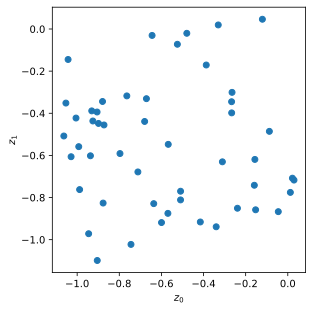

In [36]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    z = encoder(data)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

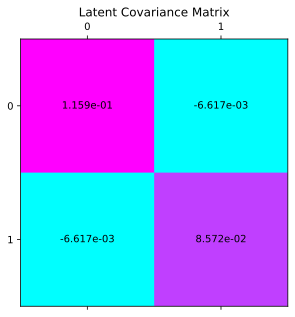

In [37]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

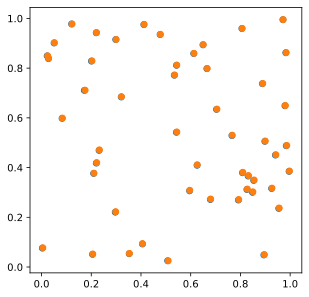

In [38]:
rec = decoder(z).detach().numpy()
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.scatter(rec[:, 0], rec[:, 1])
plt.gca().set_aspect('equal')
plt.show()

# 3D
## 1D Manifold

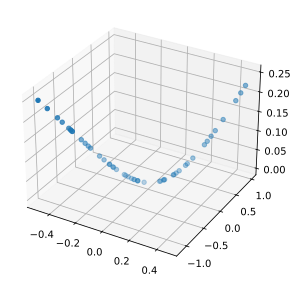

In [39]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3
Z = X ** 2
data = torch.stack([X, Y, Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
fig.show()

In [40]:
encoder = MLP(3, 3, [32]*4)
decoder = SNMLP(3, 3, [32]*4)
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    vol_loss = torch.exp(torch.log(z.std(0) + 1).mean())
    loss = rec_loss + 0.01 * vol_loss
    loss.backward()
    opt.step()

    if (i+1) % 500 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, vol_loss))

Epoch 499: rec = 0.10584428906440735, lasso = 1.0000317096710205
Epoch 999: rec = 0.00014992953219916672, lasso = 1.2006938457489014
Epoch 1499: rec = 4.697915937867947e-05, lasso = 1.1800870895385742
Epoch 1999: rec = 2.918100290116854e-05, lasso = 1.1790261268615723
Epoch 2499: rec = 2.3269449229701422e-05, lasso = 1.174745798110962
Epoch 2999: rec = 3.1251638574758545e-05, lasso = 1.1773812770843506
Epoch 3499: rec = 2.5350220312247984e-05, lasso = 1.175407886505127
Epoch 3999: rec = 2.1751598978880793e-05, lasso = 1.1726913452148438
Epoch 4499: rec = 3.271518653491512e-05, lasso = 1.1739730834960938
Epoch 4999: rec = 1.6738307749619707e-05, lasso = 1.1735621690750122
Epoch 5499: rec = 1.8063601601170376e-05, lasso = 1.1738848686218262
Epoch 5999: rec = 0.00012774825154338032, lasso = 1.1750324964523315
Epoch 6499: rec = 2.9342170819290914e-05, lasso = 1.176437497138977
Epoch 6999: rec = 2.8750908313668333e-05, lasso = 1.1788378953933716
Epoch 7499: rec = 2.1069932699901983e-05, las

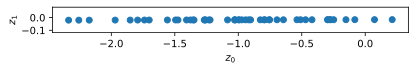

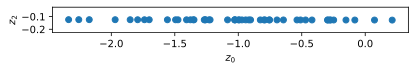

In [41]:
encoder.eval()
decoder.eval()

z = encoder(data)

with torch.no_grad():
    z = encoder(data)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy())
plt.ylim(z.mean(0)[idx[1]].cpu().detach()-0.1, z.mean(0)[idx[1]].cpu().detach()+0.1)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[2]].cpu().detach().numpy())
plt.ylim(z.mean(0)[idx[2]].cpu().detach()-0.1, z.mean(0)[idx[2]].cpu().detach()+0.1)
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_2$')
plt.show()

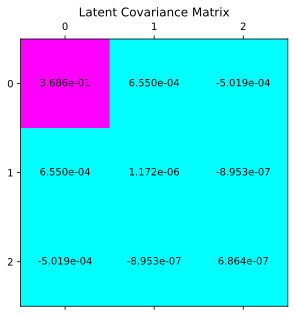

In [42]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

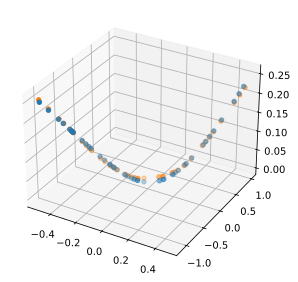

In [43]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

## 2D

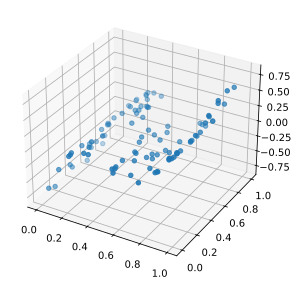

In [21]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) 
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [24]:
encoder = MLP(3, 3, [32] * 4)
decoder = SNMLP(3, 3, [32] * 4)
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    vol_loss = torch.exp(torch.log(z.std(0) + 1).mean())
    loss = rec_loss + 0.001 * vol_loss
    loss.backward()
    opt.step()

    if (i+1) % 500 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, vol_loss))

Epoch 499: rec = 0.04429559037089348, lasso = 2.2275006771087646
Epoch 999: rec = 0.03367973491549492, lasso = 2.1526408195495605
Epoch 1499: rec = 0.004481807351112366, lasso = 2.3234710693359375
Epoch 1999: rec = 0.001118018408305943, lasso = 2.3378100395202637
Epoch 2499: rec = 0.0001380729372613132, lasso = 2.2742233276367188
Epoch 2999: rec = 8.688367961440235e-05, lasso = 2.0863656997680664
Epoch 3499: rec = 6.507614307338372e-05, lasso = 1.915955901145935
Epoch 3999: rec = 5.0956226914422587e-05, lasso = 1.808632493019104
Epoch 4499: rec = 3.6067933251615614e-05, lasso = 1.6892560720443726
Epoch 4999: rec = 2.2214657292352058e-05, lasso = 1.61416494846344
Epoch 5499: rec = 2.1918664060649462e-05, lasso = 1.5552648305892944
Epoch 5999: rec = 1.986185452551581e-05, lasso = 1.526808261871338
Epoch 6499: rec = 1.7535645383759402e-05, lasso = 1.5091501474380493
Epoch 6999: rec = 1.6051268175942823e-05, lasso = 1.4767341613769531
Epoch 7499: rec = 1.604211502126418e-05, lasso = 1.4882

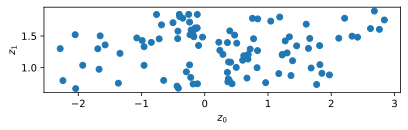

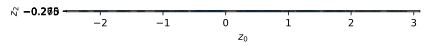

In [28]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    z = encoder(data)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[2]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_2$')
plt.show()

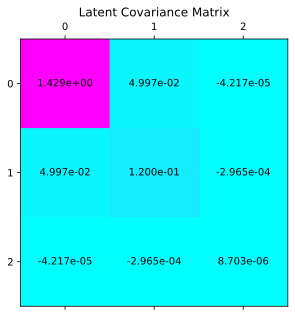

In [32]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

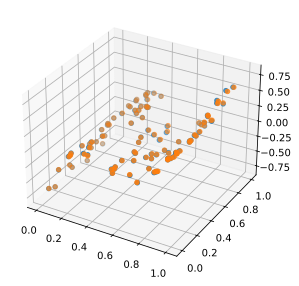

In [27]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

### 2D with Noise

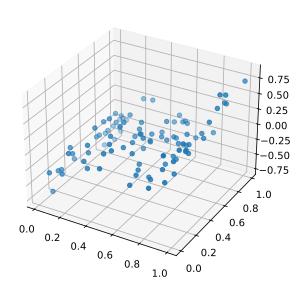

In [75]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X)) / 10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1).to('cuda:0')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [81]:
encoder = MLP(3, 3, [128]*4).to('cuda:0')
decoder = SNMLP(3, 3, [128]*4).to('cuda:0')
encoder.train()
decoder.train()
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    vol_loss = torch.exp(torch.log(z.std(0) + 0).mean())
    loss = rec_loss + 0.01 * vol_loss
    loss.backward()
    opt.step()

    if (i+1) % 500 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, vol_loss))

Epoch 499: rec = 0.0314507819712162, lasso = 0.12648554146289825
Epoch 999: rec = 0.0035833169240504503, lasso = 0.15244582295417786
Epoch 1499: rec = 0.0022165572736412287, lasso = 0.20471781492233276
Epoch 1999: rec = 0.0018256815383210778, lasso = 0.24815480411052704
Epoch 2499: rec = 0.0016506023239344358, lasso = 0.1257413774728775
Epoch 2999: rec = 0.0014480070676654577, lasso = 0.14654630422592163
Epoch 3499: rec = 0.0013403838966041803, lasso = 0.11484932154417038
Epoch 3999: rec = 0.0012251880252733827, lasso = 0.1280604600906372
Epoch 4499: rec = 0.0011124828597530723, lasso = 0.1369560956954956
Epoch 4999: rec = 0.0010563593823462725, lasso = 0.15605738759040833
Epoch 5499: rec = 0.0009786514565348625, lasso = 0.07998355478048325
Epoch 5999: rec = 0.0009145027725026011, lasso = 0.0709591880440712
Epoch 6499: rec = 0.000851780001539737, lasso = 0.07219661772251129
Epoch 6999: rec = 0.0008112412178888917, lasso = 0.06879430264234543
Epoch 7499: rec = 0.000797450658865273, lass

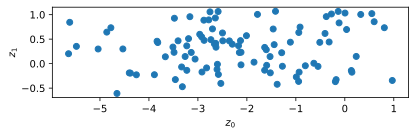

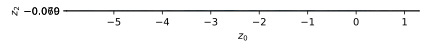

In [82]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    z = encoder(data)
idx = z.std(0).argsort(descending=True)

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_1$')
plt.show()

plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[2]].cpu().detach().numpy())
plt.gca().set_aspect('equal')
plt.xlabel('$z_0$')
plt.ylabel('$z_2$')
plt.show()

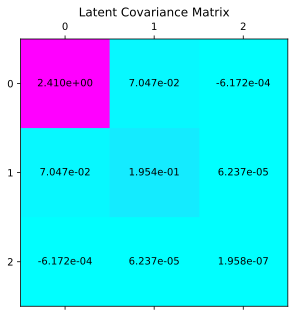

In [83]:
cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.3e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

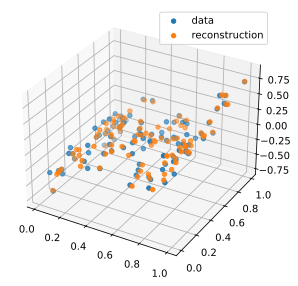

In [84]:
z = encoder(data)
rec = decoder(z).cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy(), label='data')
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2], label='reconstruction')
ax.legend()
fig.show()

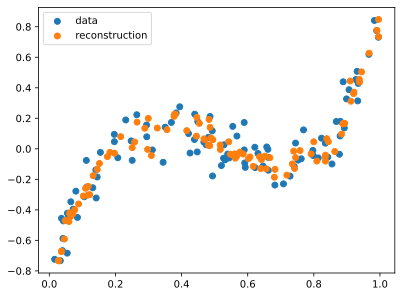

In [85]:
plt.scatter(XY[:,0].numpy(), Z.numpy(), label='data')
plt.scatter(rec[:, 0], rec[:, 2], label='reconstruction')
plt.legend()
plt.show()